# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
import plotly.express as px
import time

from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
from multiprocessing import Pool
from ipywidgets import interact, interactive, fixed, interact_manual

## 0.1. Helpers Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
   
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.float_format', '{:.2f}'.format)
    
    sns.set()


In [3]:
jupyter_settings()

## 0.2. Loading data

In [6]:
df_raw = pd.read_csv('../dataset/kc_house_data.csv', low_memory=False)

# 1.0. DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [8]:
print( f'Number of rows: {df1.shape[0]}' )
print( f'Number of columns: {df1.shape[1]}' )

Number of rows: 21613
Number of columns: 21


## 1.2. Data Dypes

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1['bathrooms'] = df1['bathrooms'].astype( 'int64' )
df1['floors'] = df1['floors'].astype( 'int64' )

In [10]:
df1.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms                 int64
sqft_living               int64
sqft_lot                  int64
floors                    int64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 1.3. Check NA

In [11]:
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1.4. Descriptive Statistical


In [12]:
num_attributes = df1.select_dtypes( include= ['float64', 'int64'] )

#mean, median, std, min, max, range, skew, kurtosis
df_mean = pd.DataFrame( num_attributes.apply( np.mean )).T
df_median = pd.DataFrame( num_attributes.apply( np.median)).T
df_std = pd.DataFrame( num_attributes.apply( np.std )).T
df_min = pd.DataFrame( num_attributes.apply( min )).T
df_max = pd.DataFrame( num_attributes.apply( max )).T
df_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
df_skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
df_kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1000102.00,9900000190.00,9899000088.00,4580301520.86,3904930410.00,2876499023.43,0.24,-1.26
1,price,75000.00,7700000.00,7625000.00,540088.14,450000.00,367118.70,4.02,34.59
2,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.97,49.06
3,bathrooms,0.00,8.00,8.00,1.75,2.00,0.73,0.90,1.99
4,sqft_living,290.00,13540.00,13250.00,2079.90,1910.00,918.42,1.47,5.24
5,sqft_lot,520.00,1651359.00,1650839.00,15106.97,7618.00,41419.55,13.06,285.08
6,floors,1.00,3.00,2.00,1.45,1.00,0.55,0.73,-0.55
7,waterfront,0.00,1.00,1.00,0.01,0.00,0.09,11.39,127.63
8,view,0.00,4.00,4.00,0.23,0.00,0.77,3.40,10.89
9,condition,1.00,5.00,4.00,3.41,3.00,0.65,1.03,0.53


# 2.0. FEATURE ENGINEERING

In [13]:
df2 = df1.copy()

## 2.1. Criação das Hipóteses

**1.** Imóveis que possuem vista para água são 20% mais caro, em média.

**2.** Imóveis com data de construção menor que 1955 são 50% mais barato, na média.

**3.** Imóveis sem porão possuem área total 40% maiores do que imóveis com porão.

**4.** O crescimento do preço dos imóveis YoY (Year over Year) é de 10%.

**5.** Imóveis novos são até 20% mais caros do que imóveis reformados.

**6.** Imóveis vendidos durante o inverno são pelo menos 10% mais baratos do que no verão.

**7.** Imóveis com vista excelente são pelo menos 20% mais caros que os demais.

**8.** Imóveis com nota de construção e design até 10, pelo menos 50% mais baratos do que os com nota acima de 10.


## 2.2. Feature Engineering

In [14]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# 3.0. FILTRAGEM DAS VARIÁVEIS

In [18]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [19]:
df3 = df3[ (df3['bedrooms'] < 33) & (df3['bathrooms'] > 0) ]

## 3.2. Filtragem das Colunas

In [20]:
cols_drop = ['sqft_above','sqft_living15', 'sqft_lot15']
df3 = df3.drop( cols_drop, axis = 1)

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [21]:
df4 = df3.copy()
df4.to_csv('df_eda.csv', index=False)

## 4.1. Análise Univariada

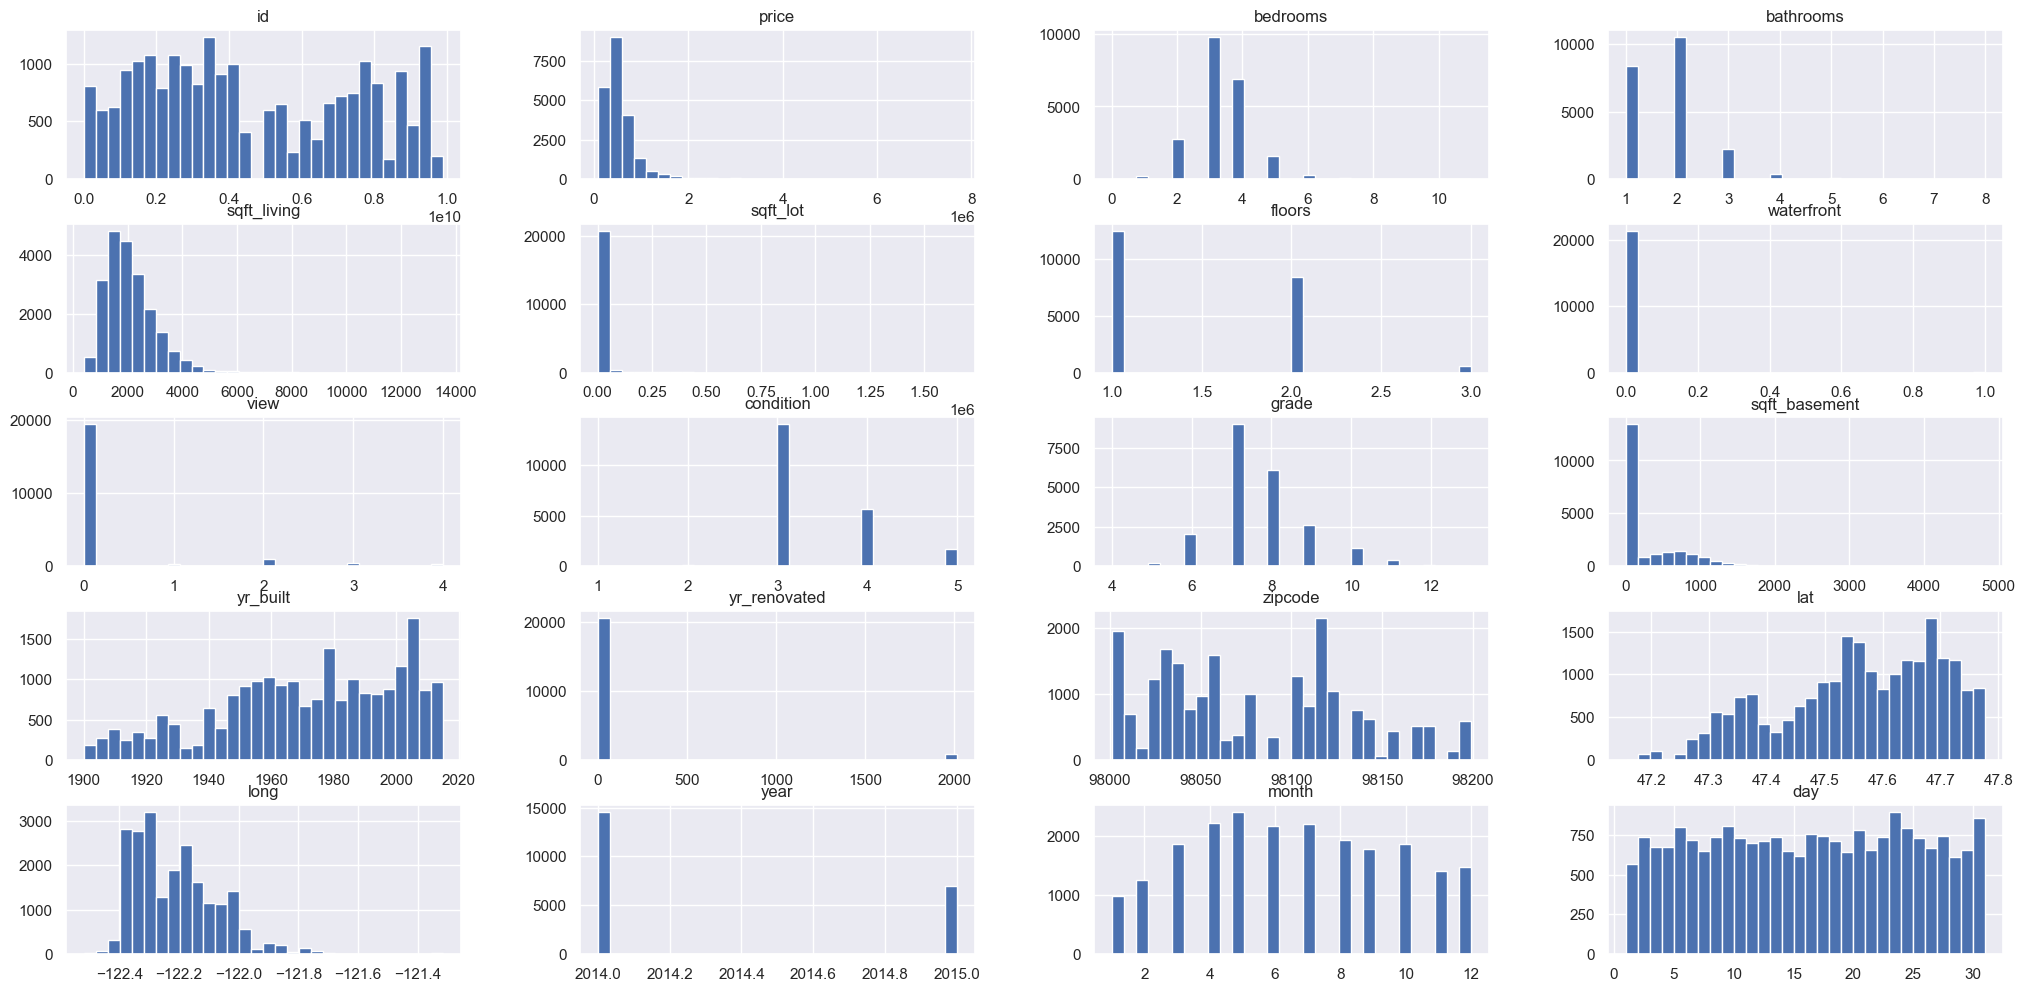

In [22]:
new_num_attributes = df4.select_dtypes( include = ['float64', 'int64'])
new_num_attributes.hist( bins = 30);

## 4.2. Análise Bivariada

### H1. Imóveis que possuem vista para água são 20% mais caro, em média.
**FALSA** Imóveis com vista para água são em média 221% mais caro

A diferença dos imóveis com vista para água é de 221%


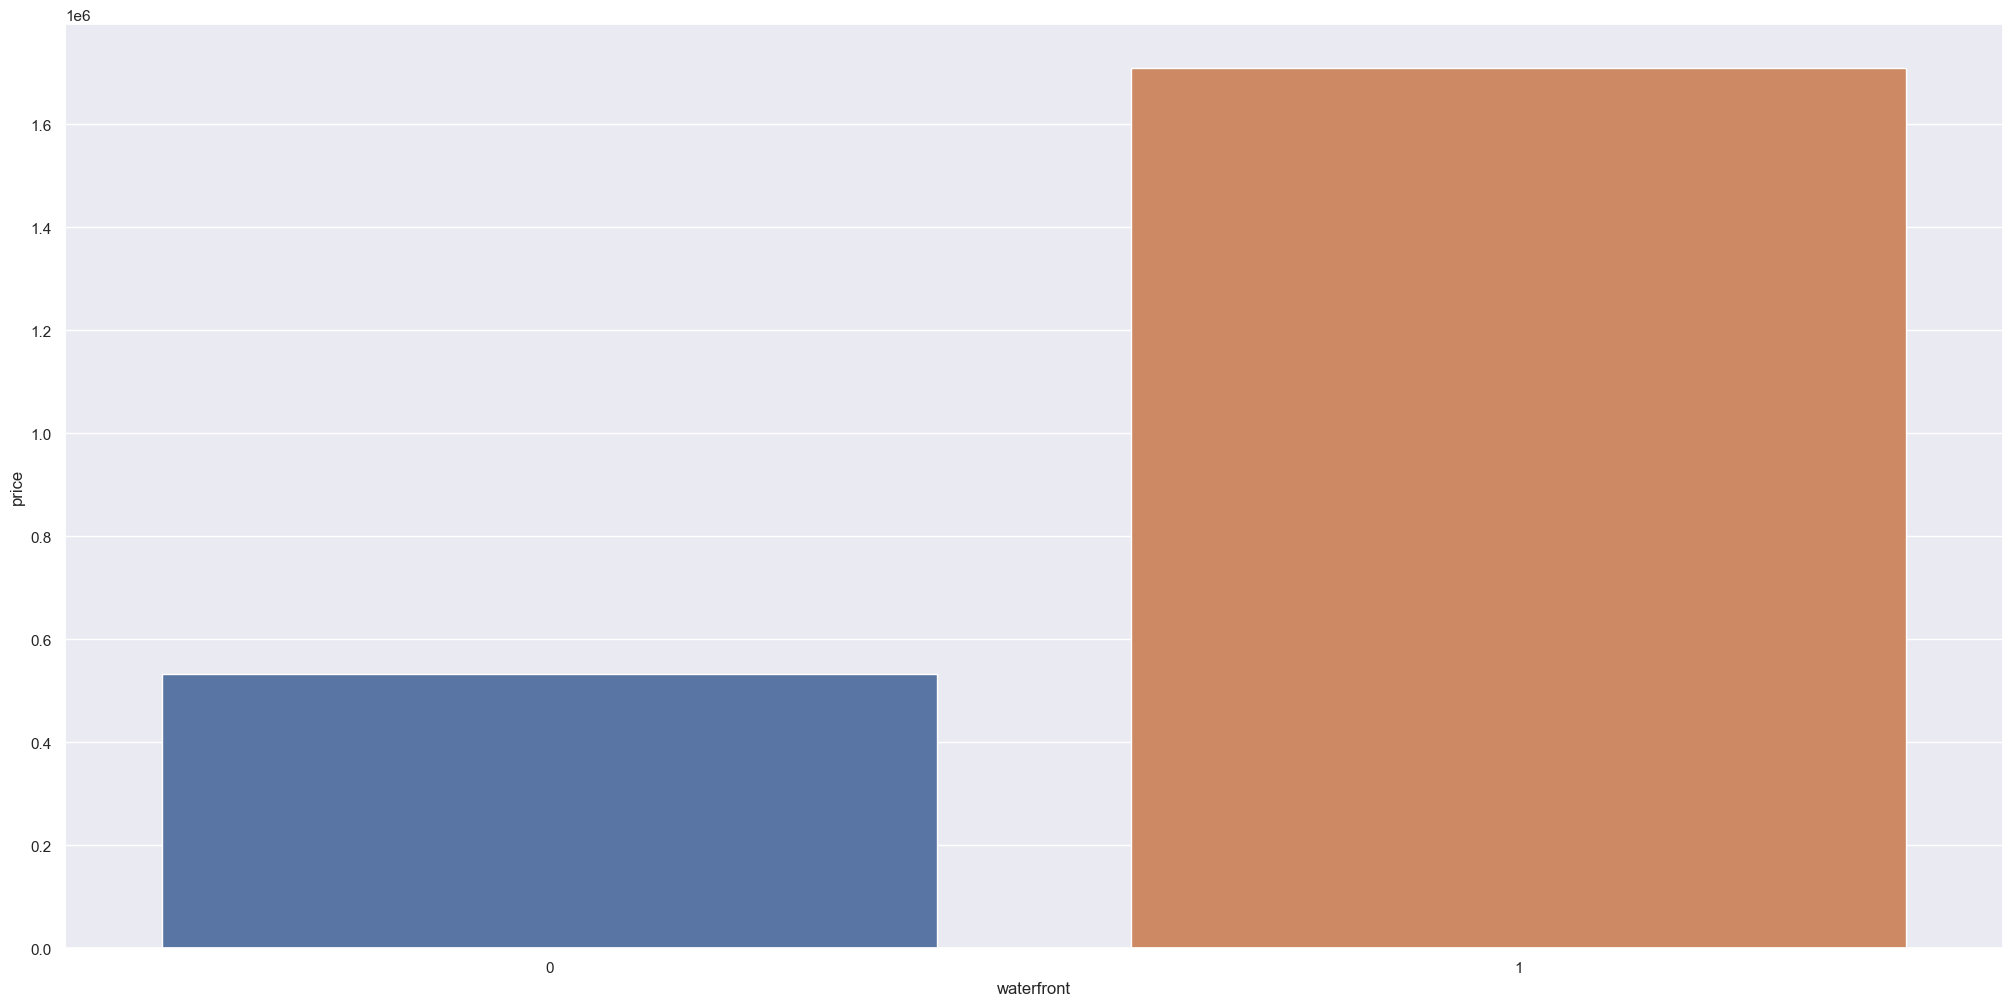

In [23]:
aux1 = df4[['waterfront', 'price']].groupby('waterfront').mean().reset_index()
aux1['percent'] = aux1['price'].pct_change()
print(f"A diferença dos imóveis com vista para água é de {aux1.loc[1, 'percent']:.0%}")

sns.barplot( data= aux1, x= 'waterfront', y='price');

### H2. Imóveis com data de construção menor que 1955 são 50% mais barato, na média.
**FALSA** Imóveis construídos antes de 1955 são 1.4% mais barato

A diferença de preço das construções de antes e após 1955 é de 1.4%


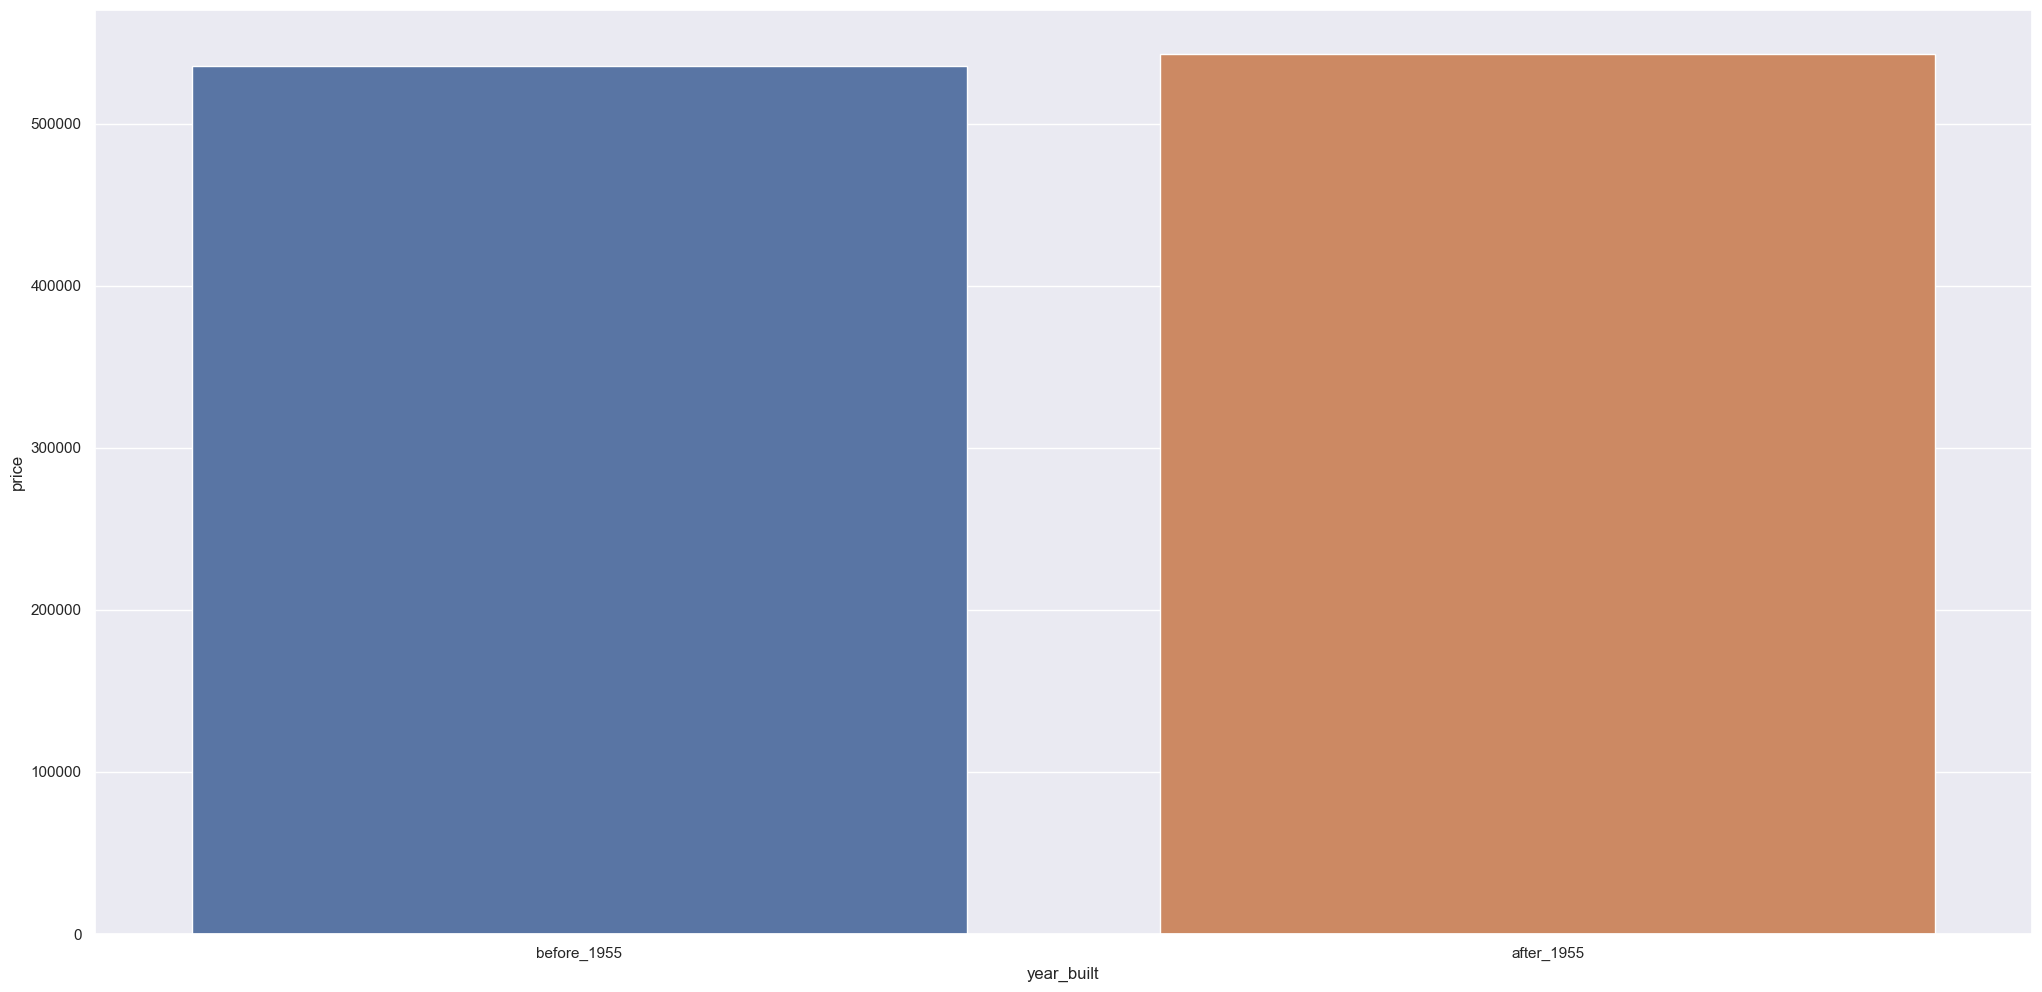

In [24]:
before_1955 = df4[ df4['yr_built'] <= 1955 ] ['price'].mean() 
after_1955 = df4[ df4['yr_built'] > 1955 ] ['price'].mean()

aux1 = pd.DataFrame( {'year_built':['before_1955', 'after_1955'], 'price': [before_1955, after_1955] } )
aux1['percent'] = aux1['price'].pct_change()

print(f'A diferença de preço das construções de antes e após 1955 é de {aux1.loc[1, "percent"]:.1%}')

sns.barplot( data = aux1, x='year_built', y='price');

In [25]:
df4.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,year,month,day
0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,0,3,7,0,1955,0,98178,47.51,-122.26,2014,10,13
1,6414100192,2014-12-09,538000.00,3,2,2570,7242,2,0,0,3,7,400,1951,1991,98125,47.72,-122.32,2014,12,9
2,5631500400,2015-02-25,180000.00,2,1,770,10000,1,0,0,3,6,0,1933,0,98028,47.74,-122.23,2015,2,25
3,2487200875,2014-12-09,604000.00,4,3,1960,5000,1,0,0,5,7,910,1965,0,98136,47.52,-122.39,2014,12,9
4,1954400510,2015-02-18,510000.00,3,2,1680,8080,1,0,0,3,8,0,1987,0,98074,47.62,-122.05,2015,2,18


### H3. Imóveis sem porão possuem área total 40% maiores do que imóveis com porão.
**FALSA** Imóveis sem porão são em média 22.44% maiores

Imóveis sem porão possuem área total 22.44% maiores


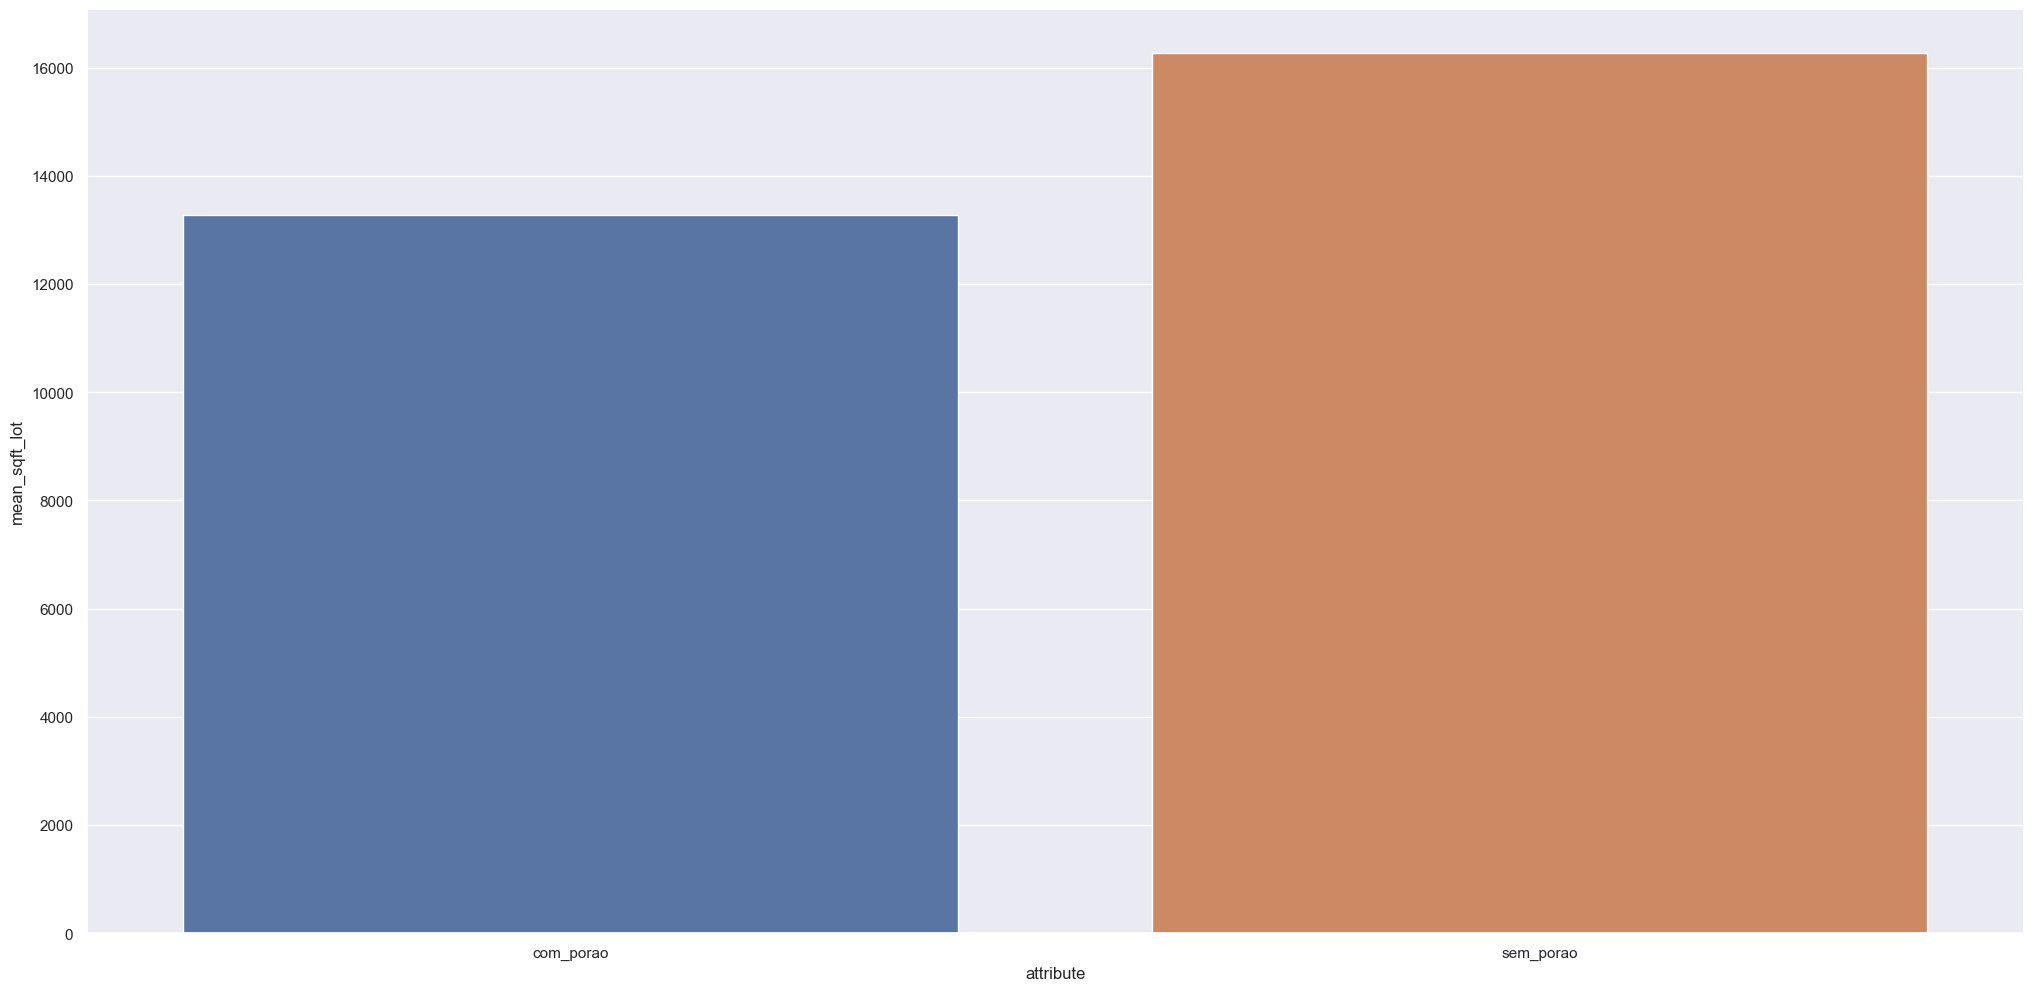

In [26]:
com_porao = df4[ df4['sqft_basement'] > 0 ] ['sqft_lot'].mean()
sem_porao = df4[ df4['sqft_basement'] == 0 ] ['sqft_lot'].mean()

aux1 = pd.DataFrame( {'attribute':['com_porao', 'sem_porao'] , 'mean_sqft_lot': [com_porao, sem_porao] } )
aux1['percent'] = aux1['mean_sqft_lot'].pct_change()
aux1

print(f'Imóveis sem porão possuem área total {aux1.loc[1, "percent"]:.2%} maiores')

sns.barplot( data= aux1, x='attribute', y='mean_sqft_lot');

In [27]:
df4.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'year', 'month', 'day'],
      dtype='object')

### H4. O crescimento do preço dos imóveis YoY (Year over Year) é de 10%.
**FALSA** O crescimento médio do preço dos imóveis ano a ano foi de 0.6%

O crescimento no preço dos imóveis ano a ano foi de 0.6%


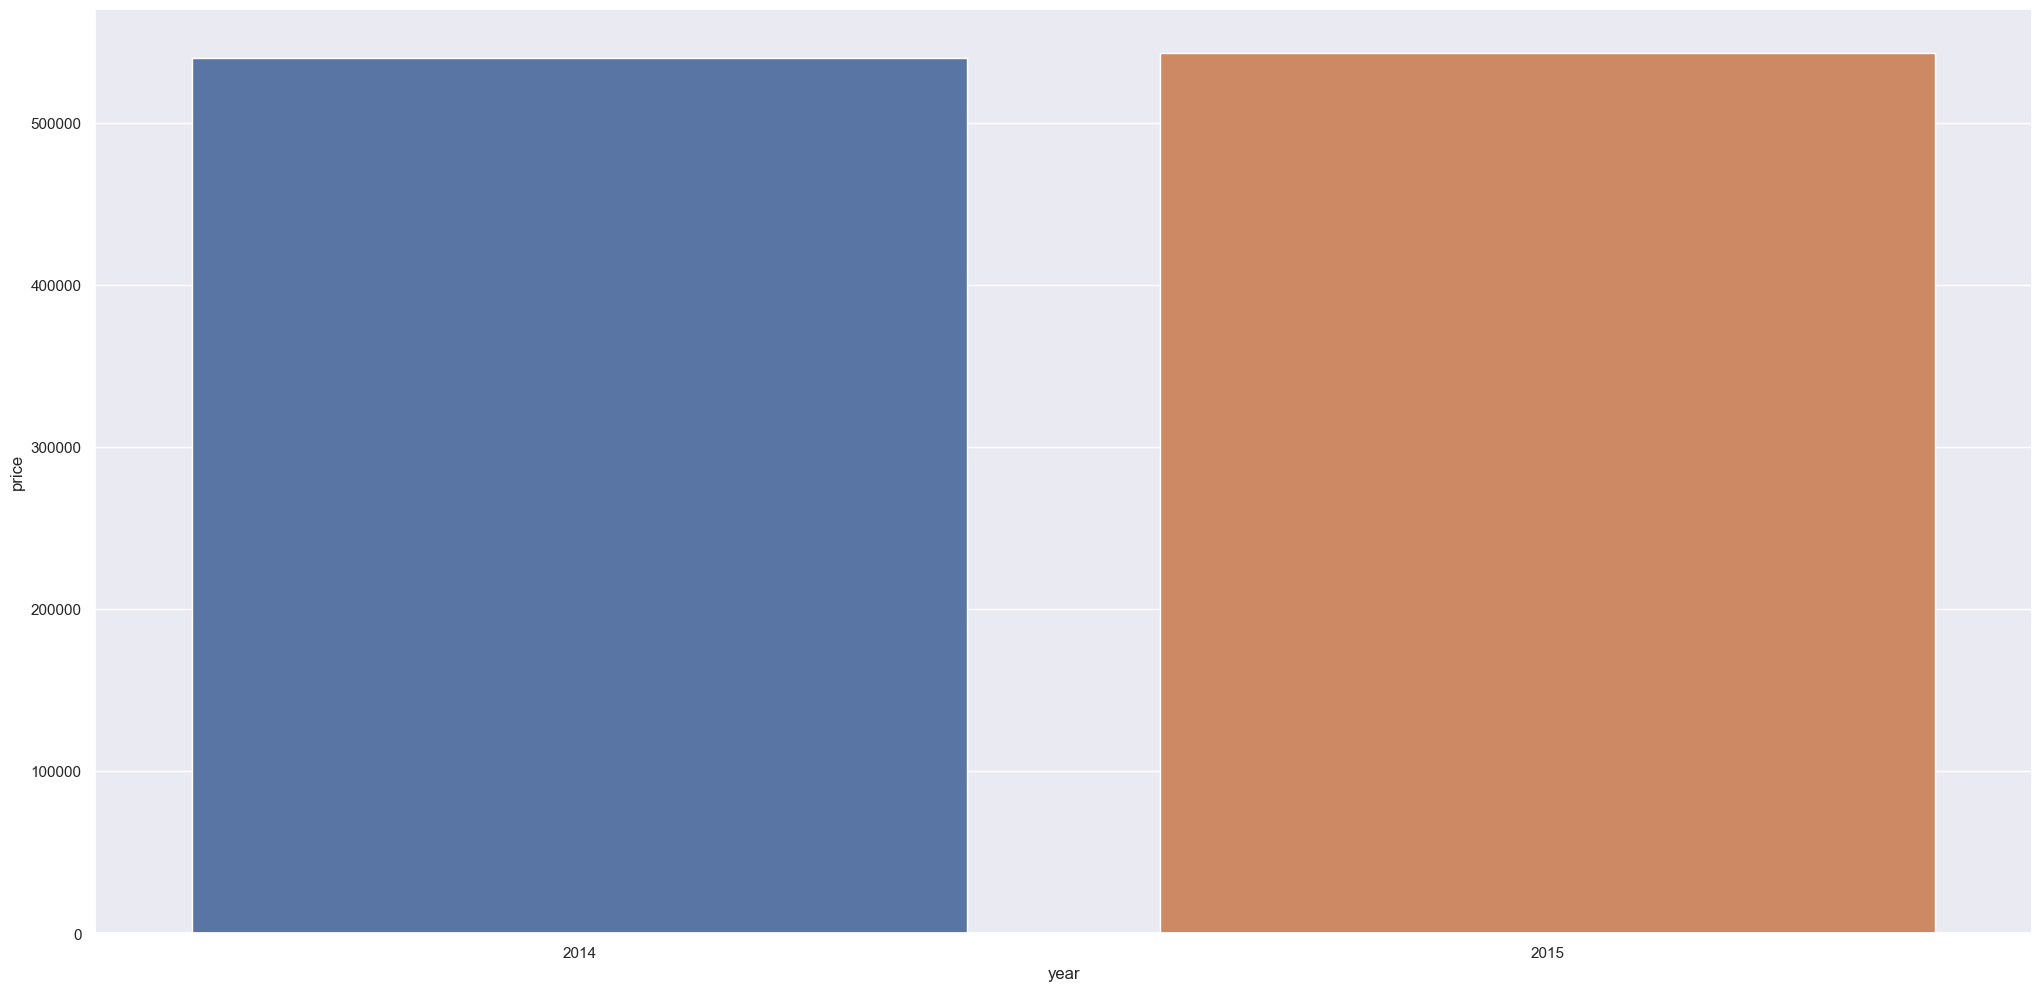

In [28]:
aux1 = df4[['year', 'price']].groupby('year').mean().reset_index()
aux1['percent'] = aux1['price'].pct_change()

print(f'O crescimento no preço dos imóveis ano a ano foi de {aux1.loc[1,"percent"]:.1%}')

sns.barplot( data = aux1, x='year', y='price');

### H5. Imóveis novos são até 20% mais caros do que imóveis reformados
**FALSA** Imóveis novos são cerca de 30% mais baratos do que os reformados

A comparação entre imóveis com reforma e sem reforma é de -30.31%


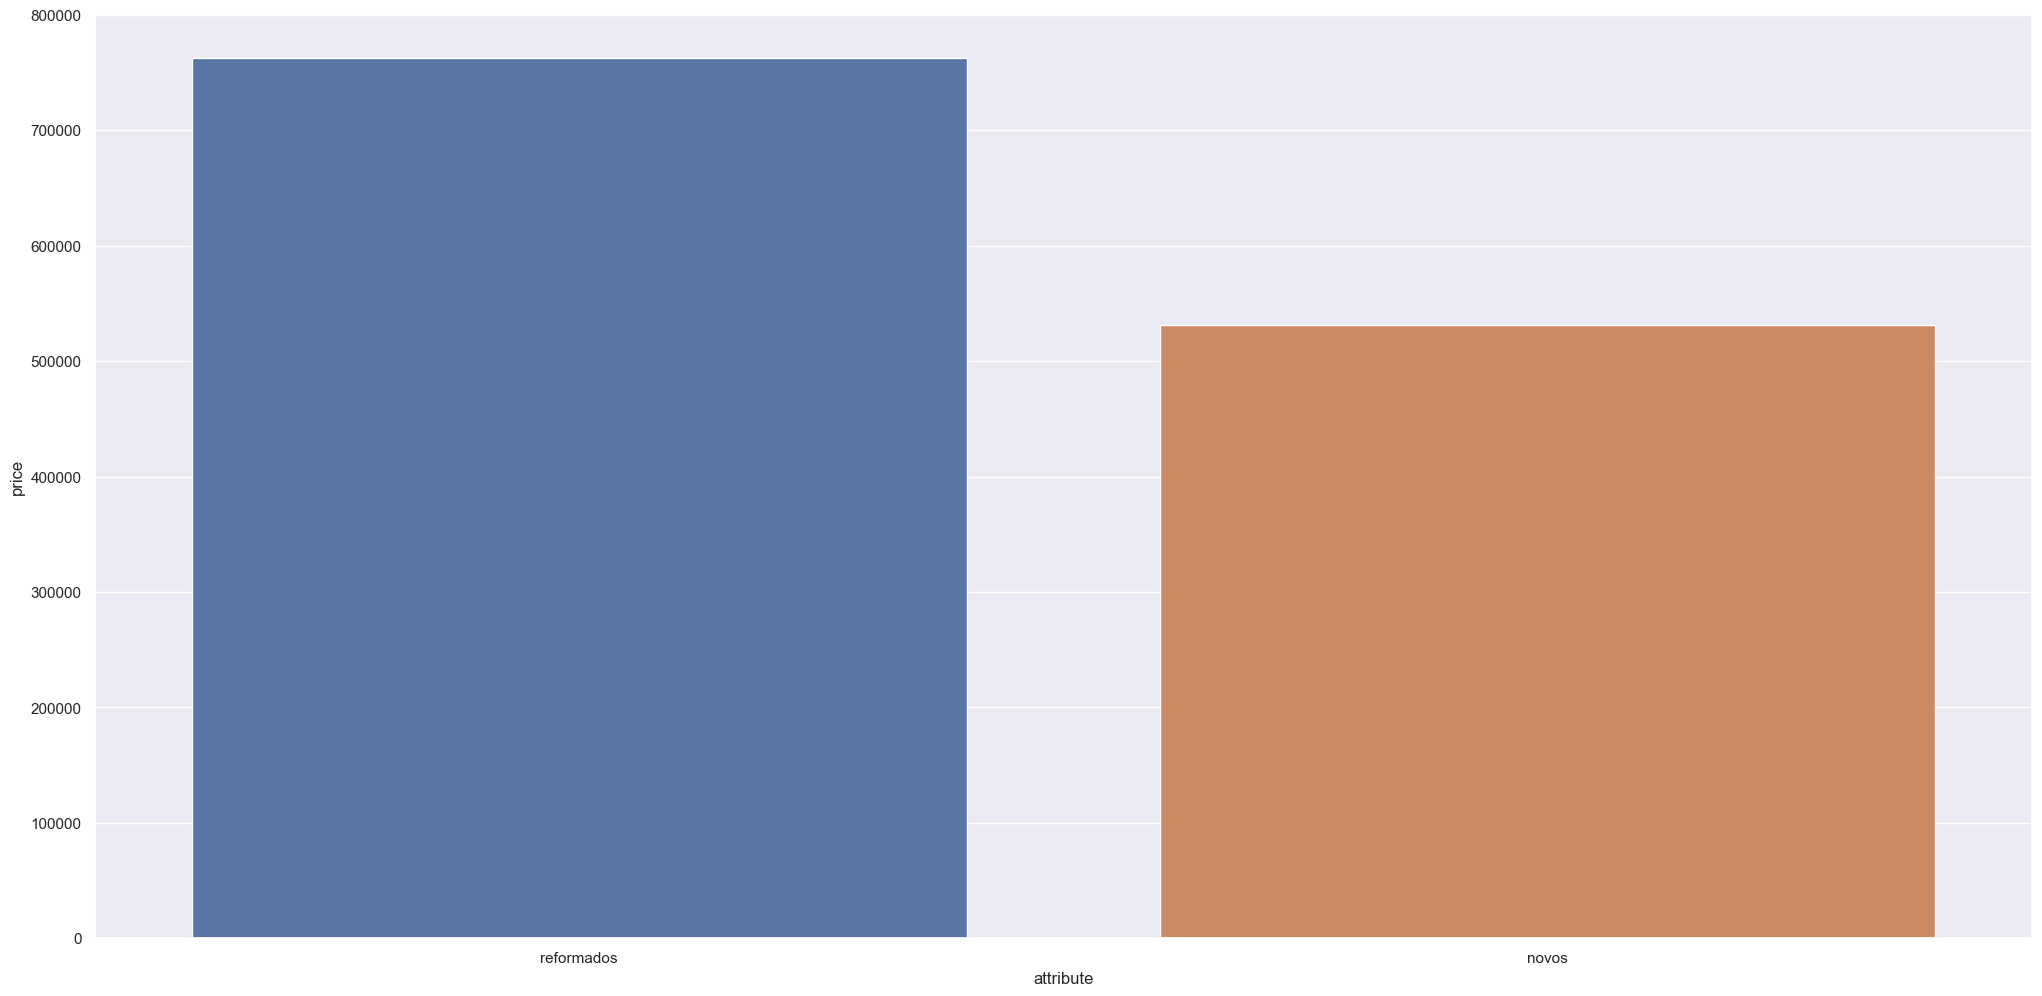

In [29]:
reformados = df4[ df4['yr_renovated'] > 0 ] ['price'].mean()
novos = df4[ df4['yr_renovated'] == 0 ] ['price'].mean()

aux1 = pd.DataFrame( {'attribute':['reformados', 'novos'] , 'price': [reformados, novos] } )
aux1['percent'] = aux1['price'].pct_change()
aux1

print(f'A comparação entre imóveis com reforma e sem reforma é de {aux1.loc[1, "percent"]:.2%}')

sns.barplot( data= aux1, x='attribute', y='price');

### H6. Imóveis vendidos durante o inverno são pelo menos 10% mais baratos do que no verão.
**FALSA** Durante o inverno, os imóveis são em média, 4.3% mais barato do que no verão

A diferença de preço entre verão e inverno é de -4.27%


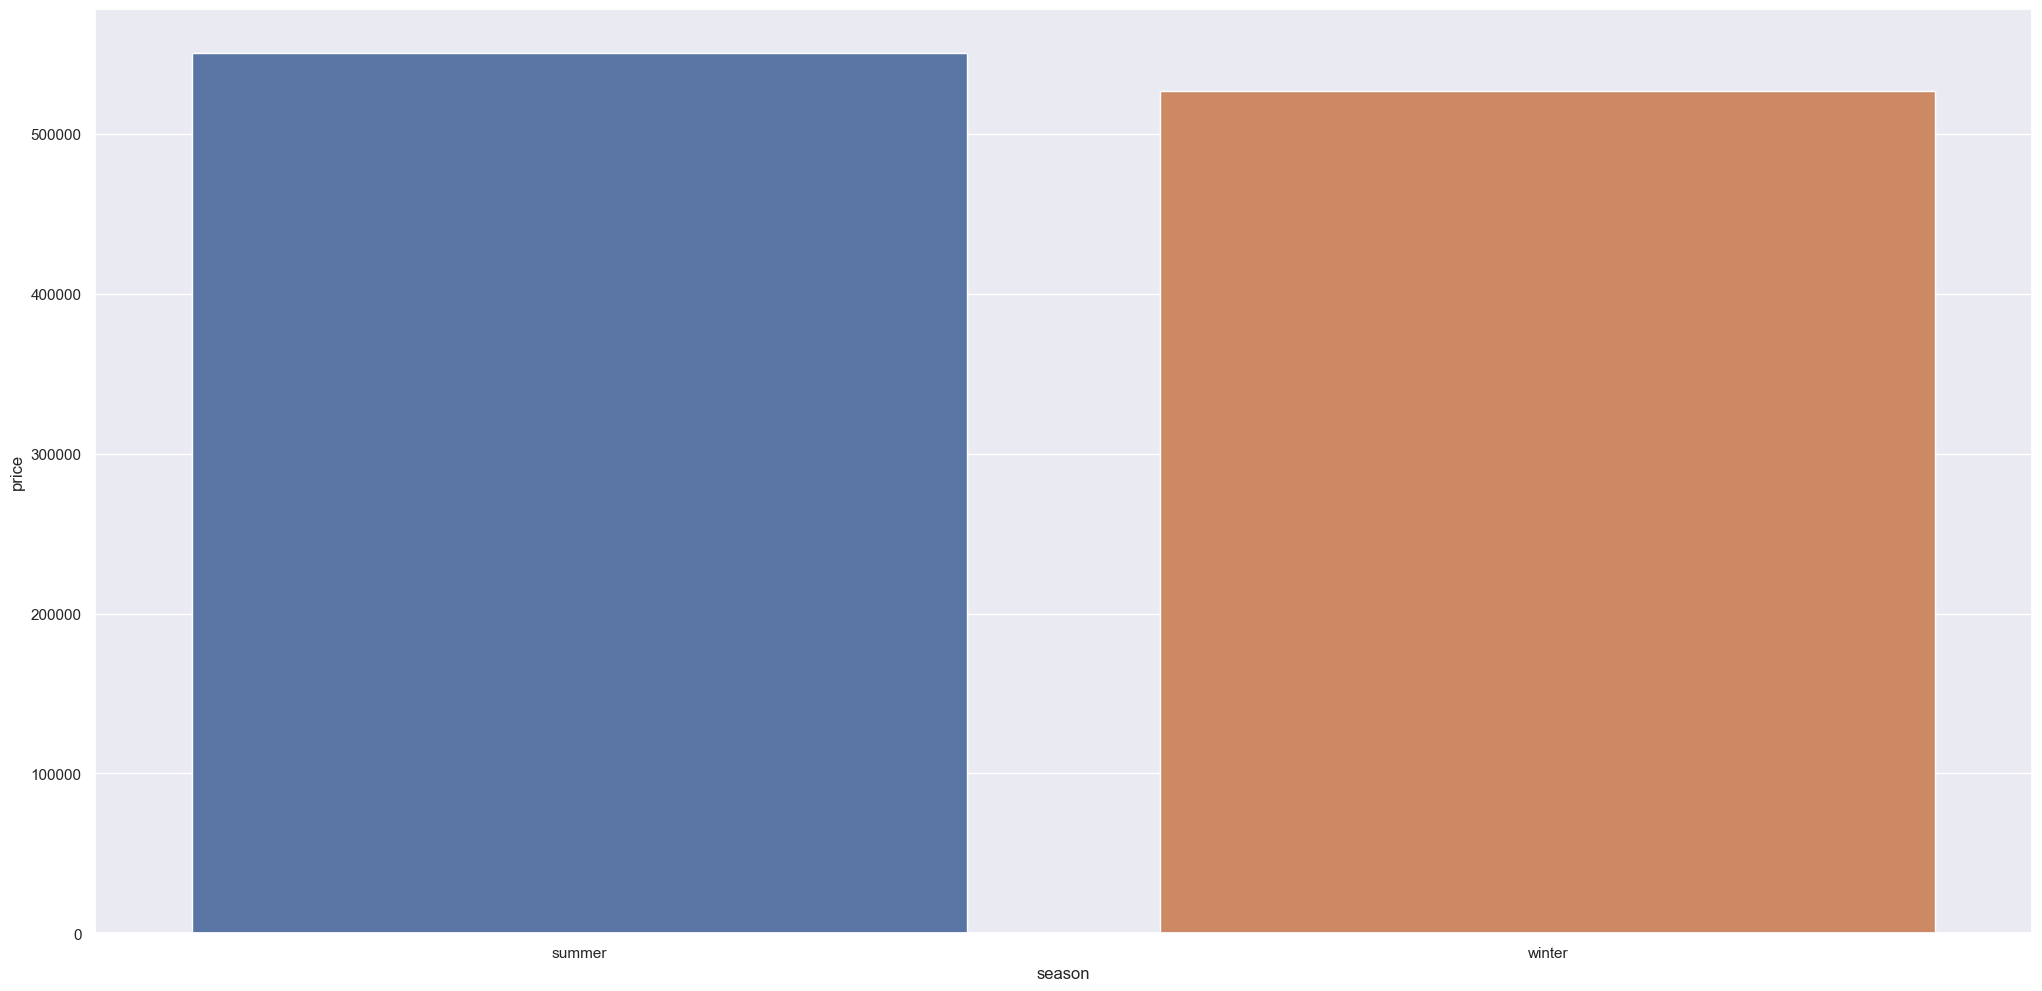

In [30]:
df4['season'] = df4['month'].apply( lambda month: 'summer' if (month >= 3 and month <= 8) else 'winter')
aux1 = df4[['season', 'price']].groupby('season').mean().reset_index()
aux1['percent'] = aux1['price'].pct_change()

print(f'A diferença de preço entre verão e inverno é de {aux1.loc[1, "percent"]:.2%}')

sns.barplot( data= aux1, x='season', y='price');

### H7. Imóveis com vista excelente (nota 4) são pelo menos 20% mais caros que os demais.
**VERDADEIRA** Imóveis com vista excelente são cerca de 51% mais caros

Imóveis com nota excelente são cerca de 51.35% mais caros


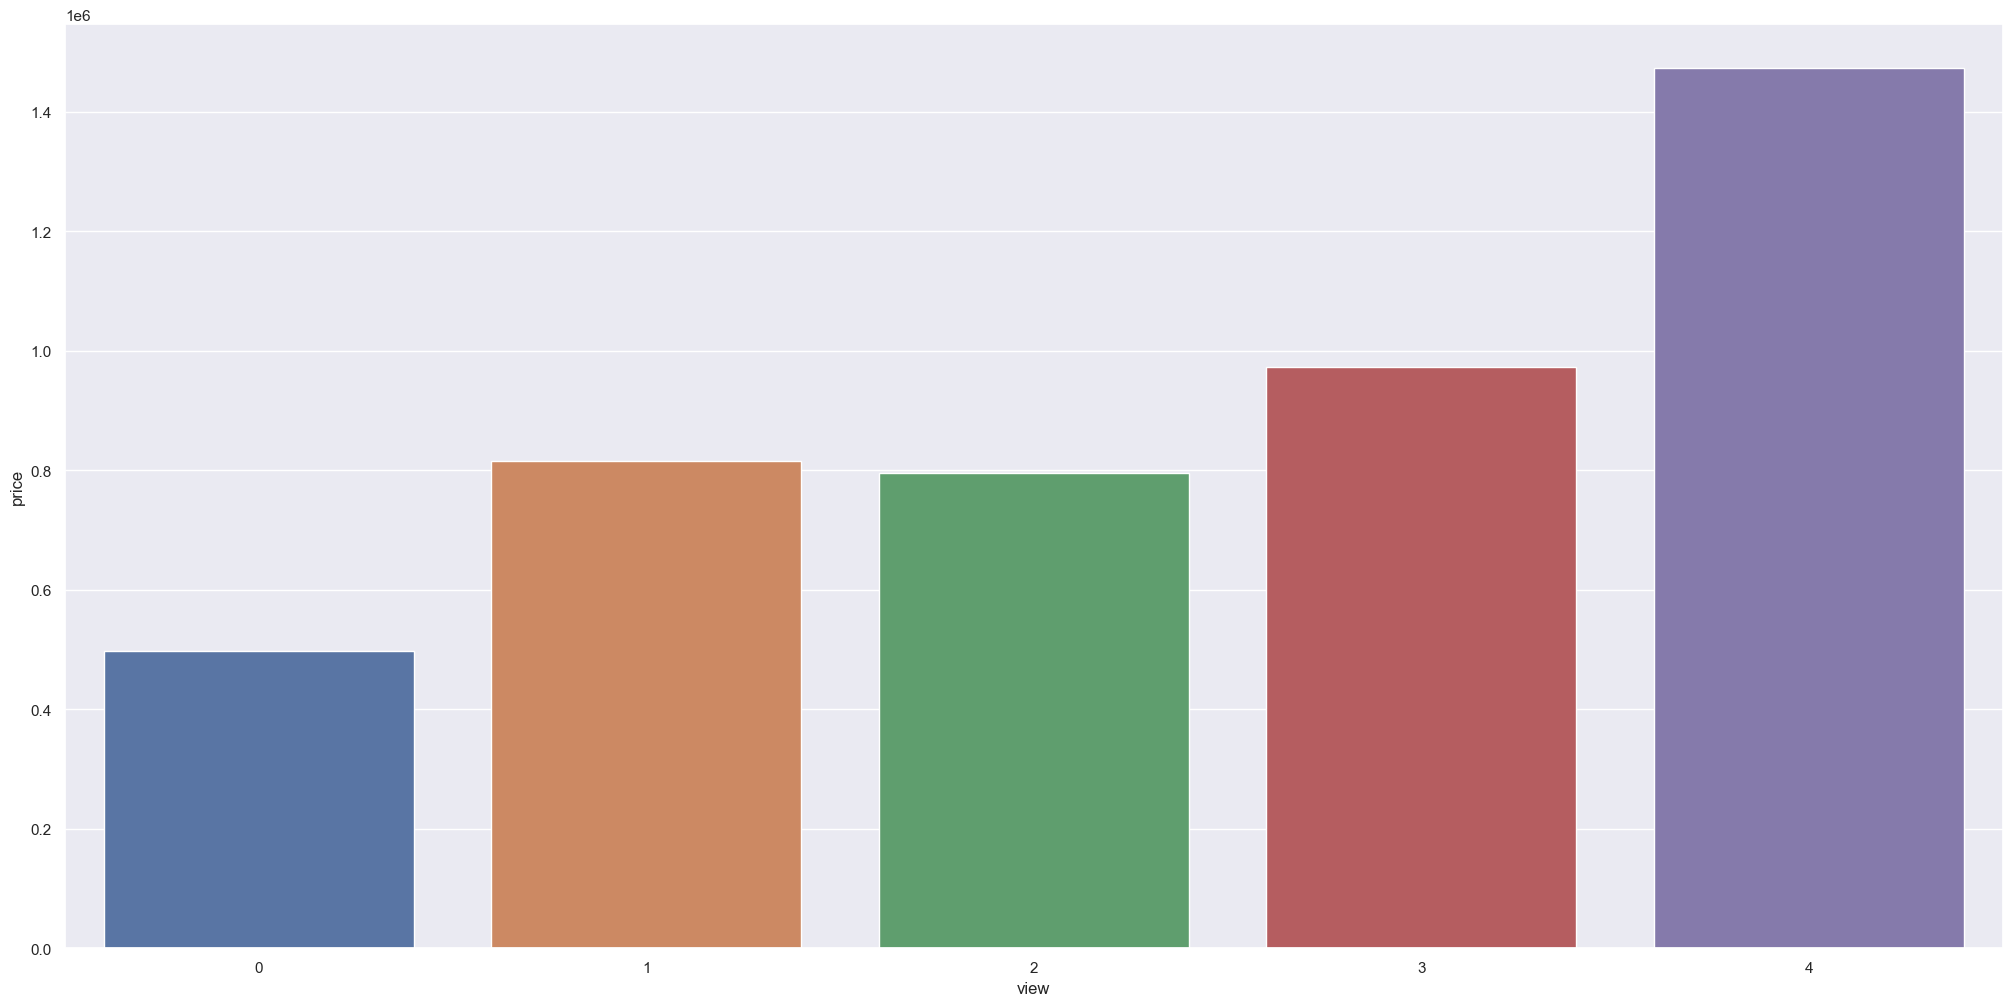

In [31]:
aux1= df4[['view', 'price']].groupby('view').mean().reset_index()
aux1['percent'] = aux1['price'].pct_change()

print(f'Imóveis com nota excelente são cerca de {aux1.loc[4,"percent"]:.2%} mais caros')

sns.barplot( data= aux1, x='view', y='price');

### H8. Imóveis com nota de construção e design até 10, pelo menos 50% mais baratos do que os com nota acima de 10.
**VERDADEIRA** Imóveis com nota acima de 10 são em média, 227% mais caros

Imóveis com nota acima de 10 são cerca de 226.81% mais caros


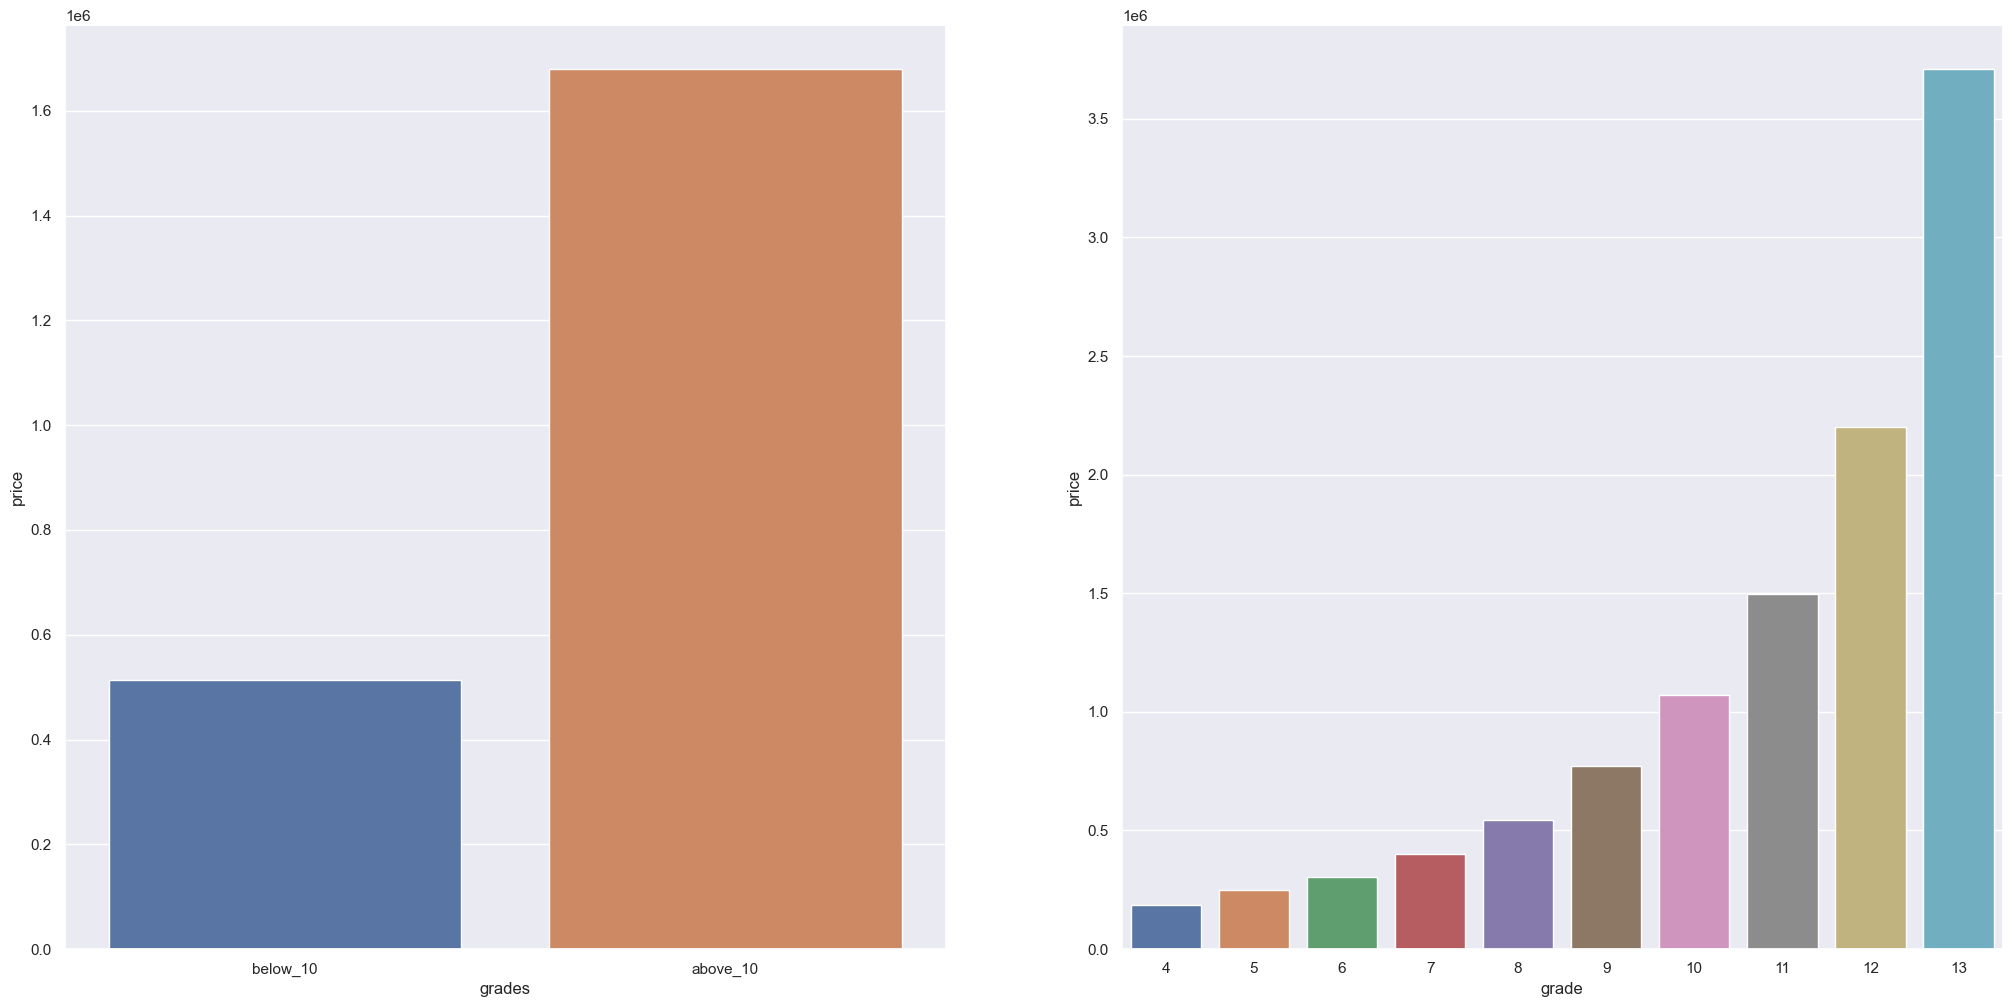

In [32]:
below_10 = df4[ df4['grade'] <= 10 ]['price'].mean()
above_10 = df4[ df4['grade'] > 10 ]['price'].mean()

aux1 = pd.DataFrame( {'grades': ['below_10', 'above_10'], 'price': [below_10, above_10] } )
aux1['percent'] = aux1['price'].pct_change()

plt.subplot(1, 2, 1)
sns.barplot( data= aux1, x='grades', y='price' );

print(f'Imóveis com nota acima de 10 são cerca de {aux1.loc[1, "percent"]:.2%} mais caros')

aux2 = df4[['grade', 'price']].groupby('grade').mean().reset_index()
aux2

plt.subplot(1, 2, 2)
sns.barplot( data= aux2, x='grade', y='price' );

# 5.0. RELATÓRIO DE COMPRA E VENDA

## 5.1. Relatório de Compra

In [34]:
df5 = df4.copy()

# criação do df com a mediana de preço por zipcode
zipcode_median_price = df5[['zipcode', 'price']].groupby('zipcode').median().reset_index()
zipcode_median_price.columns = ['zipcode', 'median_price']

df5 = pd.merge(df5, zipcode_median_price, how='inner', on='zipcode')

#filtro com base nos insights
df5['status'] = df5.apply( lambda x: 'compra' if (x['price'] < x['median_price']) & 
                                                 (x['condition'] == 5 ) & 
                                                 (x['yr_renovated'] == 0) & 
                                                 (x['view'] <= 4 ) & 
                                                 (x['grade'] <= 10) else 'não_compra', axis=1 )

# Relatório final df_buy
df_buy = df5[ df5['status'] == 'compra'] [['id', 'zipcode', 'price', 'median_price']].drop_duplicates()

df_buy.to_csv('../dataset/purchase_report.csv', index=False)

df_buy.head()

,id,zipcode,price,median_price
20,3352402236,98178,252500.00,279000.00
28,185000118,98178,212000.00,279000.00
67,8068000585,98178,235000.00,279000.00
69,7129300420,98178,258000.00,279000.00
80,1180008315,98178,212000.00,279000.00


## 5.2. Relatório de Venda

In [36]:
# criação do df com a mediana de preço por zipcode e por estação
seasonality_median_price = df5[['zipcode', 'season', 'price']].groupby(['zipcode', 'season']).median().reset_index()
seasonality_median_price.columns = ['zipcode', 'season', 'season_price']

df_sell = pd.merge( df_buy, seasonality_median_price, how='inner', on='zipcode')

# definindo preço de venda
df_sell['sell_price'] = df_sell.apply( lambda x: (x['price']*1.3) if (x['price'] < x['season_price'])
                                                              else (x['price']*1.1), axis=1 )

#Encontrar a menor diferença entre o preço de venda e a mediana da estação
df_sell['price_diff'] = abs( df_sell['sell_price'] - df_sell['season_price'] )
aux = df_sell[['id', 'price_diff']].groupby('id').min().reset_index()

df_sell = pd.merge( df_sell, aux, how='inner', on=['id', 'price_diff'])

# calculando lucro por imóvel
df_sell['profit'] = df_sell['sell_price'] - df_sell['price']

# Relatório final df_sell
df_sell = df_sell[['id', 'zipcode', 'season_price', 'median_price', 'season', 'price', 'sell_price', 'profit']].drop_duplicates()

df_sell.to_csv('../dataset/sales_report.csv', index=False)

df_sell.head()

,id,zipcode,season_price,median_price,season,price,sell_price,profit
0,3352402236,98178,281000.00,279000.00,winter,252500.00,328250.00,75750.00
1,185000118,98178,272000.00,279000.00,summer,212000.00,275600.00,63600.00
2,8068000585,98178,281000.00,279000.00,winter,235000.00,305500.00,70500.00
3,7129300420,98178,281000.00,279000.00,winter,258000.00,335400.00,77400.00
4,1180008315,98178,272000.00,279000.00,summer,212000.00,275600.00,63600.00


# 6.0. MAPA PARA VIZUALIZAÇÃO DOS IMÓVEIS

## 6.1. Preparação dos dados

In [37]:
df6 = df_buy

# Criando df com as latitudes e longitudes de cada imóvel
df_lat_long = df1[['id', 'lat', 'long', 'grade', 'view', 'waterfront']].reset_index(drop=True)
df6 = pd.merge( df6, df_lat_long, how='left', on='id').drop_duplicates().reset_index(drop=True)

# criando colunas com endereços
df6['road'] = 'NA'
df6['house_number'] = 'NA'
df6['city'] = 'NA'
df6['county'] = 'NA'
df6['state'] = 'NA'

In [38]:
# # Inicializar a API Nominatim
# geolocator = Nominatim( user_agent = 'geoapi', timeout= None)

# for i in range( len( df6 ) ):
#     query = str(df6.loc[i, 'lat']) + ',' + str(df6.loc[i, 'long'])
    
#     # API Request
#     response = geolocator.reverse(query)
#     address = response.raw['address']
    
#     # Populate address
#     if 'road' in address:
#         df6.loc[i, 'road'] = address['road']
        
#     if 'house_number' in address:
#         df6.loc[i, 'house_number'] = address['house_number']
    
#     if 'city' in address:
#         df6.loc[i, 'city'] = address['city']
    
#     if 'county' in address:
#         df6.loc[i, 'county'] = address['county']
    
#     if 'state' in address:
#         df6.loc[i, 'state'] = address['state']
        
# df6.to_csv('data_address.csv', index=False)

## 6.2. Filtros iterativos

### 6.2.1. Filtro Price_limit

In [41]:
df6 = pd.read_csv('../dataset/data_address.csv')

price_limit = widgets.IntSlider(
    value= 500000,
    min= 100000,
    max= 2000000, 
    step= 1,
    description= 'Maximum Price',
    disable= False,
    style = {'description_width': 'initial'})

### 6.2.2. Filtro Grade

In [42]:
grade_limit = widgets.IntSlider(
    value= 5,
    min= 0,
    max= 10, 
    step= 1,
    description= 'Minimum Grade',
    disable= False,
    style = {'description_width': 'initial'})

### 6.2.3. Filtro View

In [43]:
view_limit = widgets.IntSlider(
    value= 3,
    min= 0,
    max= 4, 
    step= 1,
    description= 'Minimum View',
    disable= False,
    style = {'description_width': 'initial'})

## 6.3. Mapa

In [44]:
def update_map( df, price_limit, grade_limit, view_limit):
    houses = df[ (df['price'] < price_limit) & (df['grade'] >= grade_limit) & 
                 (df['view'] >= view_limit) ].copy()
    
    fig = px.scatter_mapbox(houses,
                        lat = 'lat',
                        lon = 'long',
                        size = 'price',
                        size_max = 15,
                        text = 'road',
                        zoom = 10)

    fig.update_layout( mapbox_style = 'open-street-map')
    fig.update_layout( height = 500, margin = {'r':0, 'l':0, 't':0, 'b':0} )
    fig.show()    

In [45]:
widgets.interactive( update_map, df=fixed(df6), price_limit = price_limit, grade_limit = grade_limit, 
                                                       view_limit = view_limit )

interactive(children=(IntSlider(value=500000, description='Maximum Price', max=2000000, min=100000, style=Slid…